### <span style="color:red">CONFIGURACIÓN: EJECUTAR UNA SOLA VEZ CUANDO SE INICIA EL COLAB.</span>

In [ ]:
!git clone https://github.com/mayala-afi/econometria-mf.git

%cd econometria-mf

!pip install -q -r requirements.txt

## SESIÓN 2 : SERIES TEMPORALES

COMPROBAR QUE LA SIGUIENTE CELDA EJECUTA PARA SABER SI ESTÁ CORRECTAMENTE INSTALADO TODO

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import statsmodels

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("statsmodels:", statsmodels.__version__)


### Importación de librerías

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

from utils import plot_single_line, plot_acf_pacf, predict_plot_multi

import warnings
warnings.filterwarnings('ignore')

### 1. Carga de datos

Vamos a cargar los datos CPIAUCSL desde un Excel descargados de FRED.

In [2]:
df = pd.read_excel("./data/CPIAUCSL.xlsx", sheet_name="Monthly")

In [3]:
# Vistazo rápido a los datos
df.head()

,observation_date,CPIAUCSL
0,1947-01-01,21.48
1,1947-02-01,21.62
2,1947-03-01,22.00
3,1947-04-01,22.00
4,1947-05-01,21.95


### 2. Formateo y limpieza de datos

In [4]:
# Renombrar columnas
df.rename(columns={"observation_date": "fecha", "CPIAUCSL": "cpi"}, inplace=True)

# Convertir la columna de fechas a tipo datetime (para manipulación temporal)
df["fecha"] = pd.to_datetime(df["fecha"])
df.set_index("fecha", inplace=True)

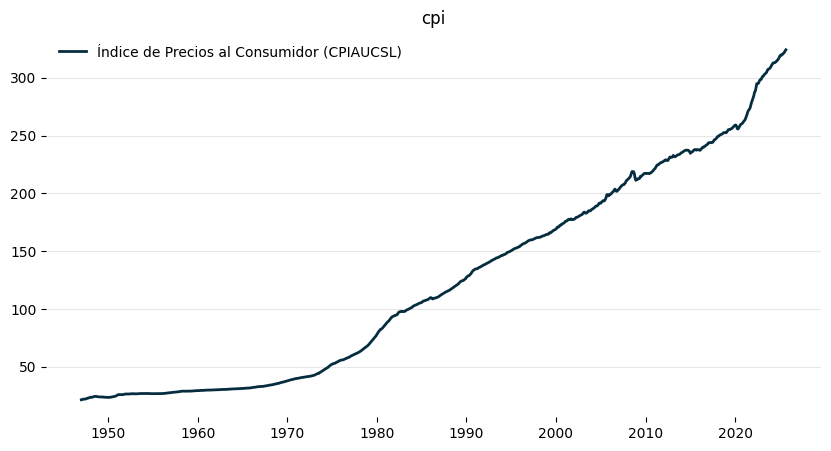

In [5]:
# Graficar la serie temporal del CPI
plot_single_line(df[["cpi"]], "cpi", "Índice de Precios al Consumidor (CPIAUCSL)")

### 3. Transformaciones

In [6]:
df["l_cpi"] = np.log(df["cpi"])
df["infl_m"] = 100 * df["l_cpi"].diff()

df = df.dropna()

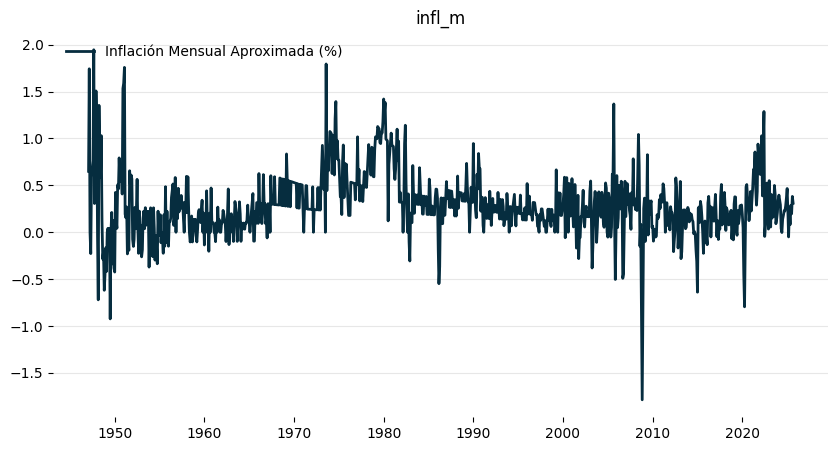

In [7]:
# Graficar la serie temporal de la inflación mensual aproximada (%)
plot_single_line(df[["infl_m"]], "infl_m", "Inflación Mensual Aproximada (%)")

### 4. Prueba ADF - raíz unitaria

In [8]:
adf_lcpi = adfuller(df["l_cpi"], maxlag=12, regression="ct") # Con tendencia y constante
print(f"ADF Log CPI:\n - Estadístico={adf_lcpi[0]:.4f}\n - p-valor={adf_lcpi[1]:.4f}")

adf_inf = adfuller(df["infl_m"], maxlag=12, regression="c") # Solo con constante
print(f"\nADF Inflación Mensual:\n - Estadístico={adf_inf[0]:.4f}\n - p-valor={adf_inf[1]:.4f}")

ADF Log CPI:
 - Estadístico=-1.1924
 - p-valor=0.9121

ADF Inflación Mensual:
 - Estadístico=-5.4614
 - p-valor=0.0000


### 5. Identificación ACF y PACF

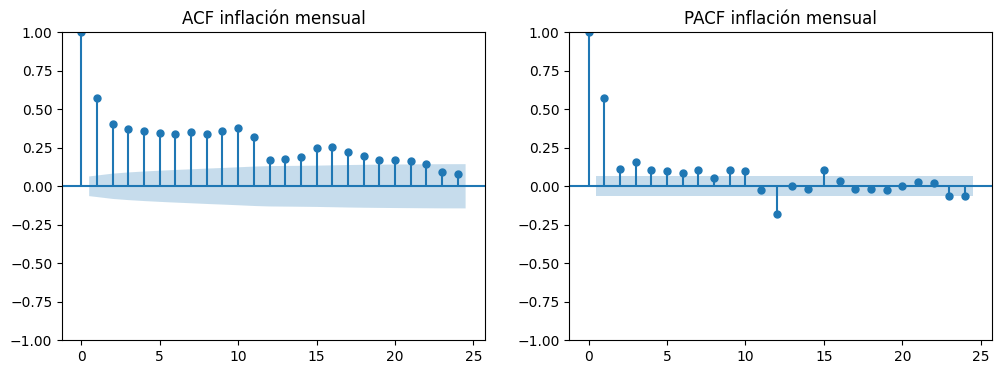

In [9]:
plot_acf_pacf(df)

### 6. Estimación ARIMA(1,1,1) sobre niveles

In [10]:
model_111 = ARIMA(df["l_cpi"], order=(1, 1, 1))
results_111 = model_111.fit()
print(results_111.summary())

                               SARIMAX Results                                
Dep. Variable:                  l_cpi   No. Observations:                  944
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4198.054
Date:                Tue, 23 Dec 2025   AIC                          -8390.109
Time:                        12:09:51   BIC                          -8375.562
Sample:                    02-01-1947   HQIC                         -8384.564
                         - 09-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8967      0.011     78.812      0.000       0.874       0.919
ma.L1         -0.3379      0.023    -14.919      0.000      -0.382      -0.294
sigma2      7.946e-06   2.01e-07     39.632      0.0

### 7. Diagnóstico de residuos

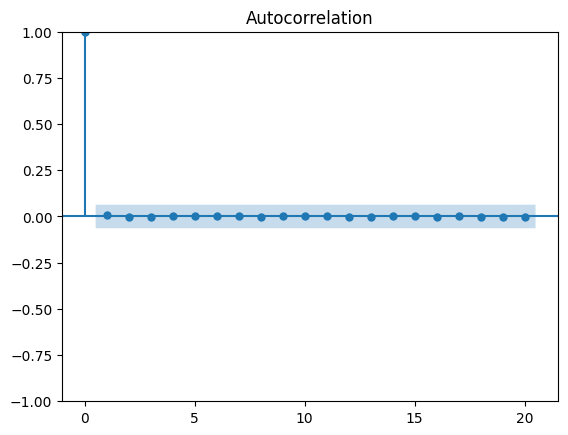

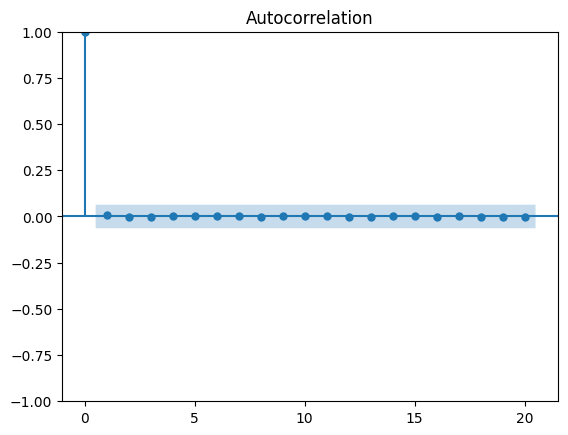

In [11]:
resid = results_111.resid

plot_acf(resid.dropna(), lags=20)

### 8. Predicción sobre inflación (ARIMA 1,0,1)

In [12]:
model_101 = ARIMA(df["infl_m"], order=(1, 0, 1))
results_101 = model_101.fit()

df["infl_m_est"] = results_101.fittedvalues

_Truncamos la muestra hasta 2023 (out-of-sample)_

In [13]:
df_train = df[df.index < "2023-12-01"]

In [14]:
model_oos = ARIMA(df_train["infl_m"], order=(1, 0, 1))
results_oos = model_oos.fit()

df["infl_m_est_out"] = results_oos.predict(start=df.index[0], end=df.index[-1])

In [15]:
df_plot = df.loc["2018-01-01":, ["infl_m", "infl_m_est", "infl_m_est_out"]]

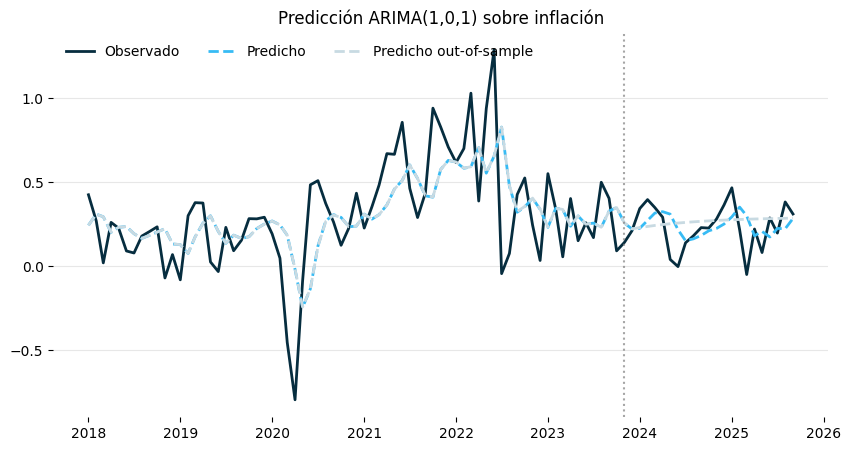

In [16]:
predict_plot_multi(
    df_plot,
    df_train,
    title="Predicción ARIMA(1,0,1) sobre inflación",
    labels=["Observado", "Predicho", "Predicho out-of-sample"],
)
